In [1]:
from ekarus.e2e.single_stage_ao_class import SingleStageAO
from ekarus.e2e.devices.pyramid_wfs import PyramidWFS

from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid
import ekarus.e2e.utils.my_fits_package as myfits
from arte.utils.radial_profile import computeRadialProfile

from numpy.ma import masked_array
import matplotlib.pyplot as plt
import xupy as xp
import os


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
tn = 'calib_amplitude'

amp = 50e-9
saveprefix = ''

ssao = SingleStageAO(tn='calib_amplitude')
ssao.initialize_turbulence()
KL, m2c = ssao.define_KL_modes(ssao.dm, zern_modes=2)
Rec, IM = ssao.compute_reconstructor(ssao.sc, KL, ssao.pyr.lambdaInM, ampsInM=amp)
ssao.sc.load_reconstructor(IM,m2c)

lambdaRef = ssao.pyr.lambdaInM

r0s = ssao.atmo_pars['r0']
windSpeeds = ssao.atmo_pars['windSpeed']
r0 = (1/xp.sum(r0s**(-5/3)))**(3/5)
Vwind = xp.mean(windSpeeds)
atmo_prefix = f'r0{r0*1e+2:1.0f}cm_V{Vwind:1.0f}_'

try:
    ma_res_screens = myfits.read_fits(os.path.join(ssao.savepath+atmo_prefix,'residual_phases.fits'))
except:
    sig2, input_sig2 = ssao.run_loop(lambdaRef, ssao.starMagnitude, save_prefix=saveprefix+atmo_prefix)


Initializing devices ...
Modulating 0 [lambda/D] with 0 modulation steps
Fried parameter is: 10.0 [cm] (seeing = 1.01")
Saving telemetry to .fits ...


Text(0.5, 1.0, 'Difference')

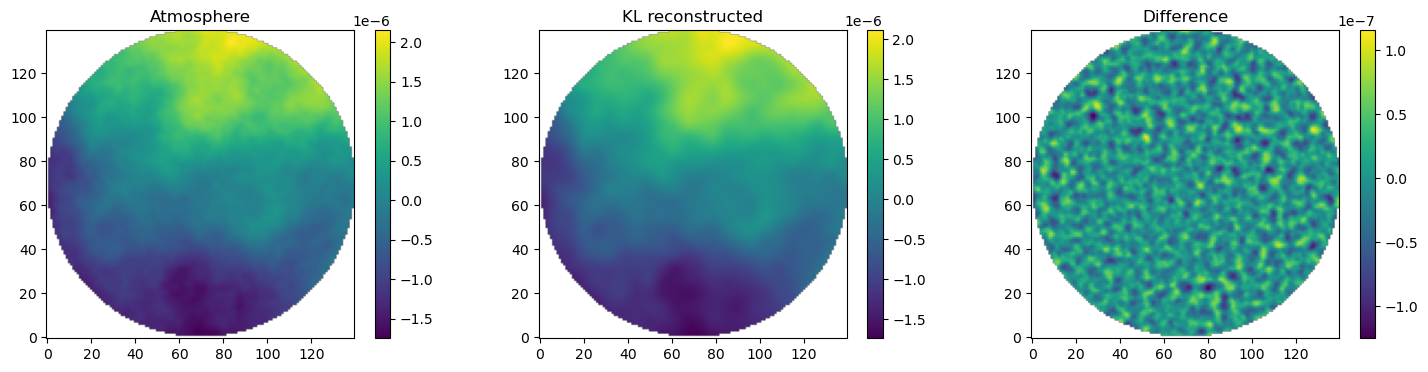

In [3]:
atmo_phase = ssao.get_phasescreen_at_time(0.6)
atmo_phase -= xp.mean(atmo_phase[~ssao.cmask])

phi = atmo_phase[~ssao.cmask]
modes = xp.linalg.pinv(KL.T) @ phi

rec_phi = KL.T @ modes
rec_phase = reshape_on_mask(rec_phi, ssao.cmask)

delta_phase = atmo_phase - rec_phase

sh = 1.0

plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.imshow(masked_array(xp.asnumpy(atmo_phase),xp.asnumpy(ssao.cmask)), origin='lower')
plt.colorbar(shrink=sh)
plt.title('Atmosphere')
plt.subplot(1,3,2)
plt.imshow(masked_array(xp.asnumpy(rec_phase),xp.asnumpy(ssao.cmask)), origin='lower')
plt.colorbar(shrink=sh)
plt.title('KL reconstructed')
plt.subplot(1,3,3)
plt.imshow(masked_array(xp.asnumpy(delta_phase),xp.asnumpy(ssao.cmask)), origin='lower')
plt.colorbar(shrink=sh)
plt.title('Difference')

# print(f'RMS of the reconstructed phase is: {xp.sqrt(xp.sum(rec_phi**2)/len(rec_phi))*1e+9:1.2f} [nm], sum of KL coefficients is: {xp.sum(abs(modes))*1e+9:1.2f} [nm]')

In [4]:
pupilDiameterInM = 8
lambdaInM = 750e-9
oversampling = 4
lambdaOverD = lambdaInM/pupilDiameterInM


apex_angle = 100*(2*xp.pi)*lambdaOverD
wfs = PyramidWFS(apex_angle, oversampling, sensorLambda=lambdaInM)
wfs.set_modulation_angle(0.0)

Modulating 0 [lambda/D] with 0 modulation steps


In [5]:
def get_mtf(wfs, phase, mask):

    phase_in_rad = reshape_on_mask(phase, mask)*2*xp.pi/wfs.lambdaInM
    input_field = (1-mask) * xp.exp(1j*phase_in_rad,dtype=wfs.cdtype)

    L = max(input_field.shape)
    padded_field = xp.pad(input_field, int((wfs.oversampling-1)/2*L), mode='constant', constant_values=0.0)
    phase_delay = wfs.pyramid_phase_delay(padded_field.shape) / lambdaOverD

    if wfs._modNsteps > 0:
        intensity = xp.zeros(padded_field.shape,dtype=wfs.dtype)
        tiltX,tiltY = wfs._get_XY_tilt_planes(padded_field.shape)
        alpha_pix = wfs.modulationAngleInLambdaOverD*wfs.oversampling*(2*xp.pi)
        phi_vec = (2*xp.pi)*xp.arange(wfs._modNsteps)/wfs._modNsteps

        for phi in phi_vec:
            tilt = tiltX * xp.cos(phi) + tiltY * xp.sin(phi)
            tilted_input = padded_field * xp.exp(1j*tilt*alpha_pix, dtype=wfs.cdtype)
            field_on_focal_plane = xp.fft.fftshift(xp.fft.fft2(tilted_input))
            ef_focal_plane_delayed = field_on_focal_plane * xp.exp(1j*phase_delay, dtype=wfs.cdtype)
            intensity += xp.abs(ef_focal_plane_delayed)**2 / wfs._modNsteps
    else:
        field_on_focal_plane = xp.fft.fftshift(xp.fft.fft2(padded_field))
        ef_focal_plane_delayed = field_on_focal_plane * xp.exp(1j*phase_delay, dtype=wfs.cdtype)
        intensity = xp.abs(ef_focal_plane_delayed)**2

    otf = xp.fft.fftshift(xp.fft.fft2(intensity))
    mtf = abs(otf)

    plt.figure()
    plt.imshow(xp.asnumpy(xp.log(mtf)),origin='lower',cmap='twilight')
    # plt.imshow(masked_array(xp.asnumpy(xp.log(mtf)),xp.asnumpy(~padded_mask)),origin='lower',cmap='twilight')
    plt.colorbar()

    return mtf

In [6]:

# def radial_order(i_mode):
#     noll = i_mode + 2
#     return xp.ceil(-3.0/2.0+xp.sqrt(1+8*noll)/2.0)

# corr_gains = 1.0/xp.sqrt(radial_order(xp.arange(KL.shape[0])))
# print(corr_gains)

# pc_modes = modes*corr_gains
# rec_phi_pc = KL.T @ pc_modes

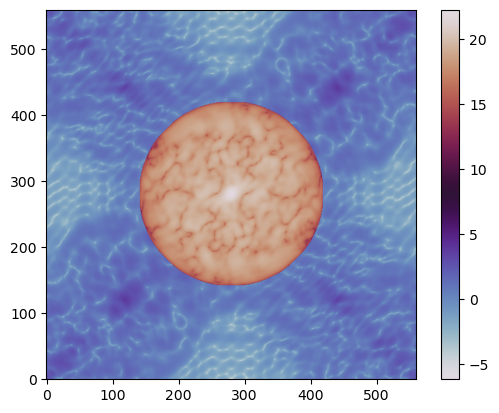

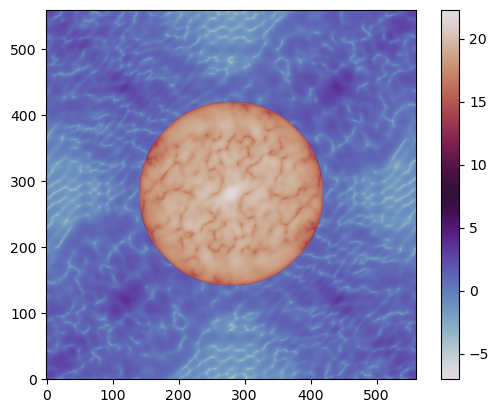

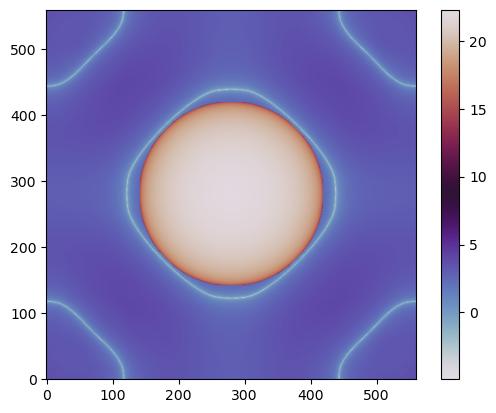

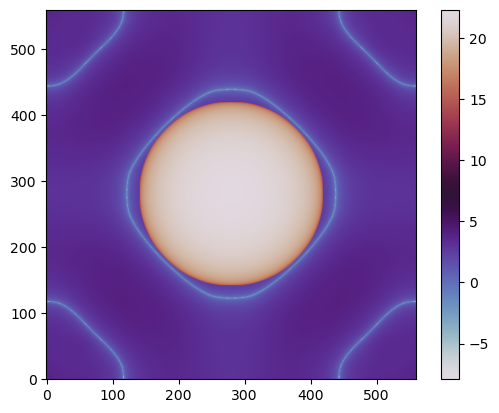

In [7]:
mtf = get_mtf(wfs, phi, ssao.cmask)
rmtf = get_mtf(wfs, rec_phi, ssao.cmask)
dmtf = get_mtf(wfs, phi-rec_phi, ssao.cmask)
mtf0 = get_mtf(wfs, phi*0, ssao.cmask)

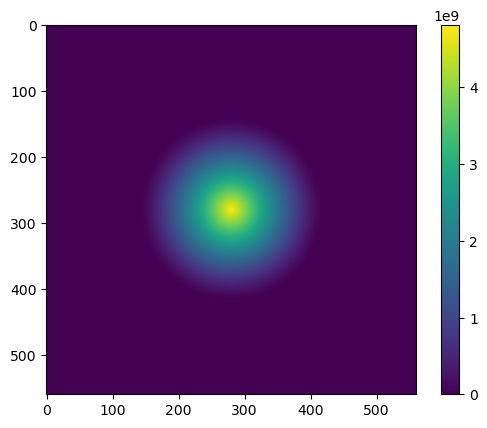

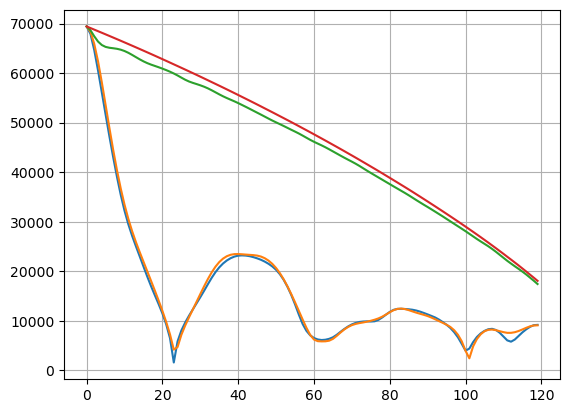

In [8]:
plt.figure()
plt.imshow(xp.asnumpy(mtf0))
plt.colorbar()

plt.figure()
plt.plot(xp.asnumpy(xp.sqrt(mtf[280,280:400])))
plt.plot(xp.asnumpy(xp.sqrt(rmtf[280,280:400])))
plt.plot(xp.asnumpy(xp.sqrt(dmtf[280,280:400])))
plt.plot(xp.asnumpy(xp.sqrt(mtf0[280,280:400])))
plt.grid()
# plt.yscale('log')
# plt.yscale('log')

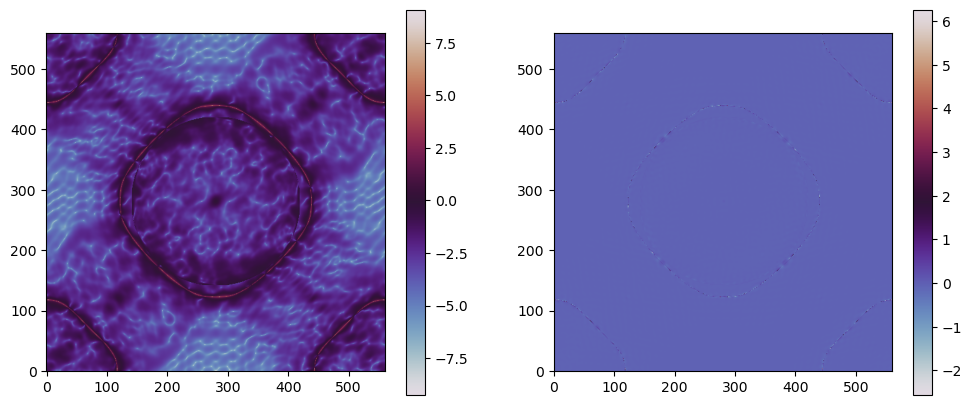

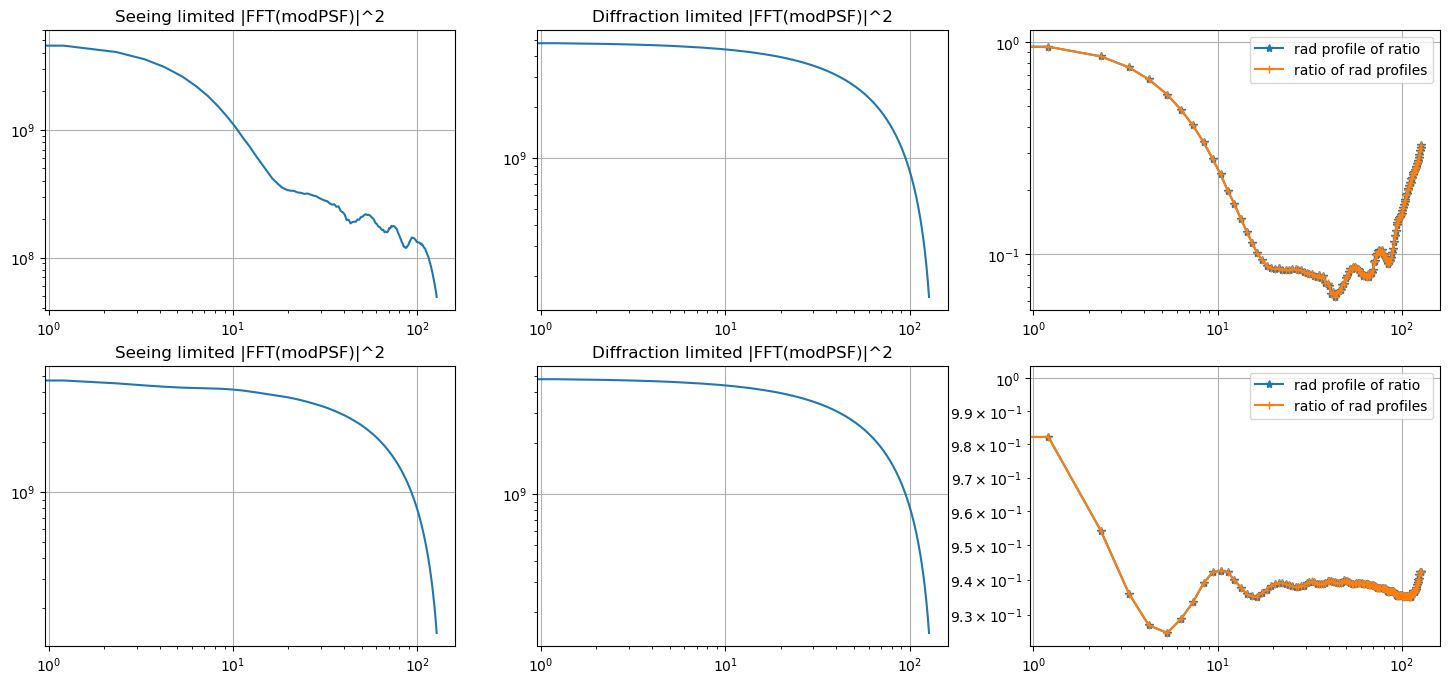

In [9]:
ratio = mtf/mtf0
dratio = dmtf/mtf0
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(xp.log(ratio)),origin='lower',cmap='twilight')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(xp.log(dratio)),origin='lower',cmap='twilight')
plt.colorbar()

Npix = max(xp.shape(dratio))
rad_mtf, distance = computeRadialProfile(xp.asnumpy(mtf), centerInPxX=Npix//2, centerInPxY=Npix//2)
rad_dmtf, distance = computeRadialProfile(xp.asnumpy(dmtf), centerInPxX=Npix//2, centerInPxY=Npix//2)
rad_mtf0, distance = computeRadialProfile(xp.asnumpy(mtf0), centerInPxX=Npix//2, centerInPxY=Npix//2)
rad_ratio, distance = computeRadialProfile(xp.asnumpy(ratio), centerInPxX=Npix//2, centerInPxY=Npix//2)
rad_dratio, distance = computeRadialProfile(xp.asnumpy(dratio), centerInPxX=Npix//2, centerInPxY=Npix//2)

Nmax = 128
plt.figure(figsize=(18,8))
plt.subplot(2,3,1)
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy(rad_mtf[:Nmax]))
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title('Seeing limited |FFT(modPSF)|^2')
plt.subplot(2,3,2)
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy(rad_mtf0[:Nmax]))
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title('Diffraction limited |FFT(modPSF)|^2')
plt.subplot(2,3,3)
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy(rad_ratio[:Nmax]),'-*',label='rad profile of ratio')
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy((rad_mtf/rad_mtf0)[:Nmax]),'-+',label='ratio of rad profiles')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.subplot(2,3,4)
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy(rad_dmtf[:Nmax]))
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title('Seeing limited |FFT(modPSF)|^2')
plt.subplot(2,3,5)
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy(rad_mtf0[:Nmax]))
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title('Diffraction limited |FFT(modPSF)|^2')
plt.subplot(2,3,6)
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy(rad_dratio[:Nmax]),'-*',label='rad profile of ratio')
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy((rad_dmtf/rad_mtf0)[:Nmax]),'-+',label='ratio of rad profiles')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')

In [10]:
x,y = ssao.dm.act_coords

IFs = ssao.dm.IFF.copy()
Rec = xp.linalg.pinv(IFs)

mask = ssao.dm.mask.copy()
X,Y = image_grid(mask.shape,recenter=True)
X = X[~mask]
Y = Y[~mask]

N = 64
M = int(xp.sum(1-mask))
s = xp.pi / (xp.max(X) - xp.min(X))
idx = xp.arange(N, dtype=int)[:, None] 
fourier_mat = xp.cos(idx * s * X[None, :])
fourier_inv = xp.linalg.pinv(fourier_mat)


(300.0, 540.0)

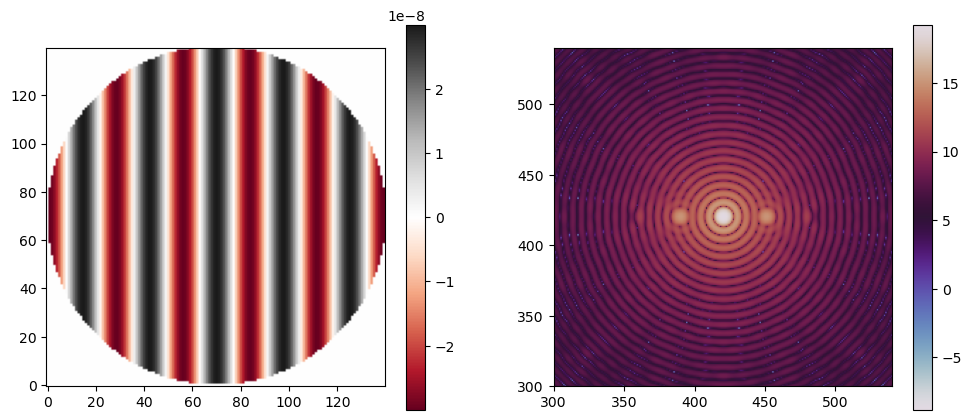

In [11]:
mode10 = fourier_mat[10,:]
mode20 = fourier_mat[20,:]
amp = 30e-9
shape = reshape_on_mask(mode10*amp,mask)
oversampling = 6
input_field =(1-mask) * xp.exp(1j*shape*2*xp.pi/lambdaInM,dtype=xp.complex128)
padded_field = xp.pad(input_field, pad_width=int(max(input_field.shape)*(oversampling-1))//2, mode='constant', constant_values=0.0+0.0*1j)
focal_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
psf = xp.abs(focal_field)**2

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(shape),origin='lower',cmap='RdGy')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(xp.log(psf)),origin='lower',cmap='twilight')
plt.colorbar()
plt.xlim([50*oversampling,90*oversampling])
plt.ylim([50*oversampling,90*oversampling])

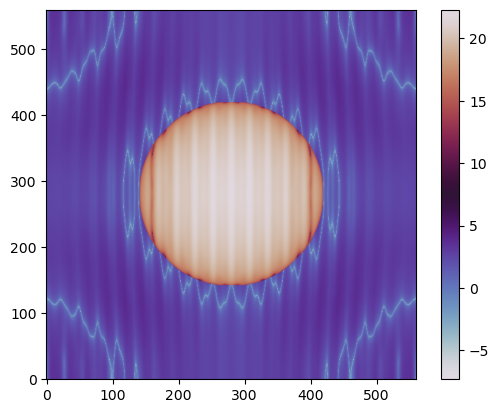

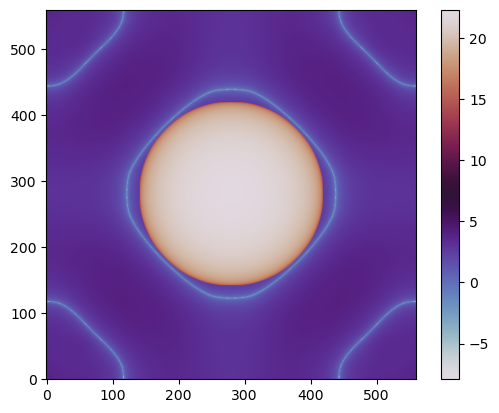

In [12]:
fourier_phase = mode10 * 100e-9 + mode20 * 80e-9
mtf = get_mtf(wfs, fourier_phase, ssao.cmask)
mtf0 = get_mtf(wfs, fourier_phase*0, ssao.cmask)

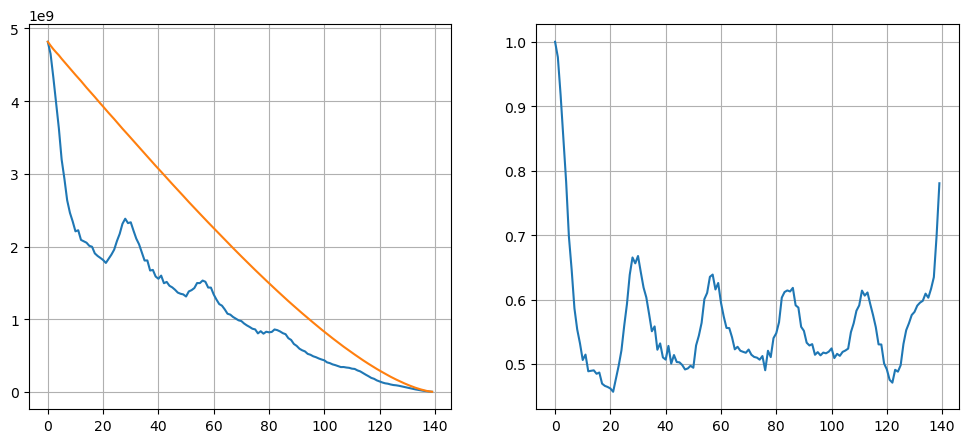

In [13]:
rad_mtf, distance = computeRadialProfile(xp.asnumpy(mtf), centerInPxX=Npix//2, centerInPxY=Npix//2)
rad_mtf0, distance = computeRadialProfile(xp.asnumpy(mtf0), centerInPxX=Npix//2, centerInPxY=Npix//2)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(rad_mtf[:Npix//4]))
plt.plot(xp.asnumpy(rad_mtf0[:Npix//4]))
plt.grid()
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(rad_mtf[:Npix//4]/rad_mtf0[:Npix//4]))
plt.grid()

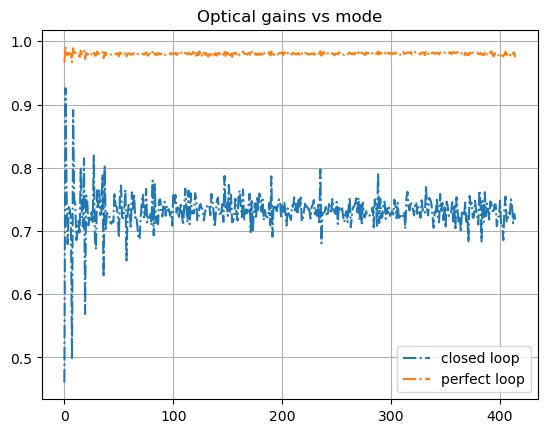

In [14]:
fourier_phase = xp.reshape(fourier_phase,(1,xp.size(fourier_phase)))
amp = 50e-9

cl_opt_gains, pl_opt_gains = ssao.calibrate_optical_gains_from_precorrected_screens(
                                fourier_phase,
                                slope_computer=ssao.sc, MM=KL, IM=IM,
                                save_prefix = 'fourier_phase_', ampsInM=amp)
plt.figure()
plt.plot(xp.asnumpy(cl_opt_gains),'-.',label='closed loop')
plt.plot(xp.asnumpy(pl_opt_gains),'-.',label='perfect loop')
plt.legend()
plt.title('Optical gains vs mode')
plt.grid()

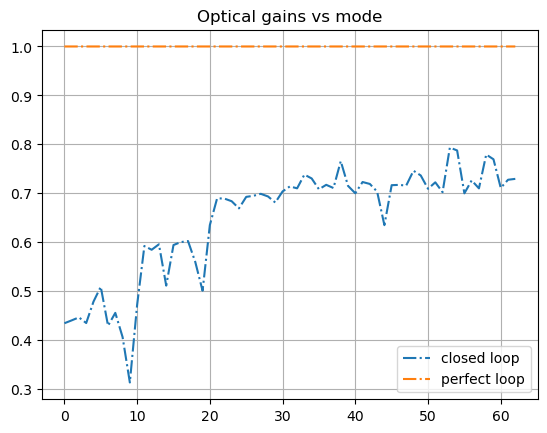

In [15]:
fourier_phase = xp.reshape(fourier_phase,(1,xp.size(fourier_phase)))
amp = 50e-9

_, fourier_IM = ssao.compute_reconstructor(ssao.sc, fourier_mat, ssao.pyr.lambdaInM, ampsInM=amp, save_prefix='fourier_modes_')
ssao.sc.load_reconstructor(fourier_IM,m2c)
cl_opt_gains, pl_opt_gains = ssao.calibrate_optical_gains_from_precorrected_screens(
                                fourier_phase,
                                slope_computer=ssao.sc, MM=fourier_mat,
                                save_prefix = 'fourier_modes_', ampsInM=amp)
plt.figure()
plt.plot(xp.asnumpy(cl_opt_gains[1:]),'-.',label='closed loop')
plt.plot(xp.asnumpy(pl_opt_gains[1:]),'-.',label='perfect loop')
plt.legend()
plt.title('Optical gains vs mode')
plt.grid()

Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration amplitudes: 50-9.1 [nm] (419-76 [mrad])
Calibration 

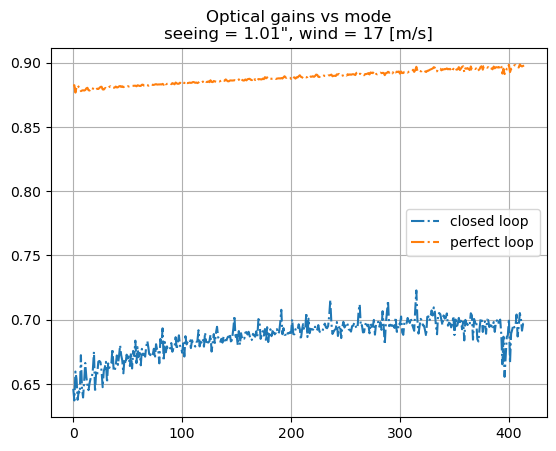

In [16]:
ma_res_screens = myfits.read_fits(os.path.join(ssao.savepath,atmo_prefix+'residual_phases.fits'))
offset = 100
N = 40
loop_residual_phases = xp.zeros([N,int(xp.sum(1-ssao.cmask))])
step = (xp.shape(xp.asarray(ma_res_screens.data))[0]-offset)//N
for j in range(N):
    loop_residual_phases[j,:] = xp.asarray(ma_res_screens[j*step+offset].data[~ma_res_screens[j*step+offset].mask])

ssao.sc.load_reconstructor(IM,m2c)
cl_opt_gains, pl_opt_gains = ssao.calibrate_optical_gains_from_precorrected_screens(
                                loop_residual_phases,
                                slope_computer=ssao.sc, MM=KL, 
                                save_prefix = atmo_prefix, ampsInM=amp)
plt.figure()
plt.plot(xp.asnumpy(cl_opt_gains),'-.',label='closed loop')
plt.plot(xp.asnumpy(pl_opt_gains),'-.',label='perfect loop')
plt.legend()
plt.title(f'Optical gains vs mode\nseeing = {0.98*500e-9/r0*180/xp.pi*3600:1.2f}", wind = {Vwind:1.0f} [m/s]')
plt.grid()

Text(0, 0.5, 'OG')

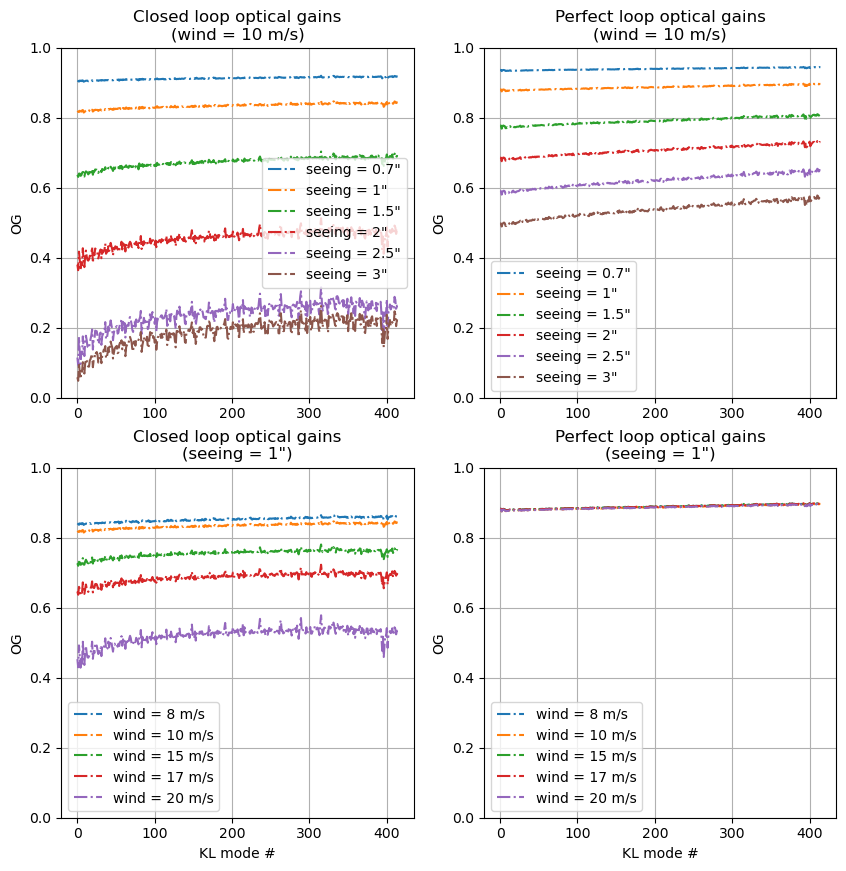

In [17]:
cl_r15_V10 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r015cm_V10_closed_loop_OG.fits'))
pl_r15_V10 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r015cm_V10_perfect_loop_OG.fits'))
cl_r10_V10 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r010cm_V10_closed_loop_OG.fits'))
pl_r10_V10 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r010cm_V10_perfect_loop_OG.fits'))
cl_r6_V10 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r06cm_V10_closed_loop_OG.fits'))
pl_r6_V10 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r06cm_V10_perfect_loop_OG.fits'))
cl_r5_V10 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r05cm_V10_closed_loop_OG.fits'))
pl_r5_V10 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r05cm_V10_perfect_loop_OG.fits'))
cl_r4_V10 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r04cm_V10_closed_loop_OG.fits'))
pl_r4_V10 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r04cm_V10_perfect_loop_OG.fits'))
cl_r3_V10 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r03cm_V10_closed_loop_OG.fits'))
pl_r3_V10 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r03cm_V10_perfect_loop_OG.fits'))

cl_r10_V20 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r010cm_V20_closed_loop_OG.fits'))
pl_r10_V20 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r010cm_V20_perfect_loop_OG.fits'))
cl_r10_V17 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r010cm_V17_closed_loop_OG.fits'))
pl_r10_V17 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r010cm_V17_perfect_loop_OG.fits'))
cl_r10_V15 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r010cm_V15_closed_loop_OG.fits'))
pl_r10_V15 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r010cm_V15_perfect_loop_OG.fits'))
cl_r10_V8 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r010cm_V8_closed_loop_OG.fits'))
pl_r10_V8 = myfits.read_fits(os.path.join(ssao.savecalibpath,'r010cm_V8_perfect_loop_OG.fits'))

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(xp.asnumpy(cl_r15_V10),'-.',label='seeing = 0.7"')
plt.plot(xp.asnumpy(cl_r10_V10),'-.',label='seeing = 1"')
plt.plot(xp.asnumpy(cl_r6_V10),'-.',label='seeing = 1.5"')
plt.plot(xp.asnumpy(cl_r5_V10),'-.',label='seeing = 2"')
plt.plot(xp.asnumpy(cl_r4_V10),'-.',label='seeing = 2.5"')
plt.plot(xp.asnumpy(cl_r3_V10),'-.',label='seeing = 3"')
plt.ylim([0,1.0])
plt.grid()
plt.legend()
plt.title('Closed loop optical gains\n(wind = 10 m/s)')
plt.ylabel('OG')
plt.subplot(2,2,2)
plt.plot(xp.asnumpy(pl_r15_V10),'-.',label='seeing = 0.7"')
plt.plot(xp.asnumpy(pl_r10_V10),'-.',label='seeing = 1"')
plt.plot(xp.asnumpy(pl_r6_V10),'-.',label='seeing = 1.5"')
plt.plot(xp.asnumpy(pl_r5_V10),'-.',label='seeing = 2"')
plt.plot(xp.asnumpy(pl_r4_V10),'-.',label='seeing = 2.5"')
plt.plot(xp.asnumpy(pl_r3_V10),'-.',label='seeing = 3"')
plt.grid()
plt.ylim([0,1.0])
plt.legend()
plt.title('Perfect loop optical gains\n(wind = 10 m/s)')
plt.ylabel('OG')
plt.subplot(2,2,3)
plt.plot(xp.asnumpy(cl_r10_V8),'-.',label='wind = 8 m/s')
plt.plot(xp.asnumpy(cl_r10_V10),'-.',label='wind = 10 m/s')
plt.plot(xp.asnumpy(cl_r10_V15),'-.',label='wind = 15 m/s')
plt.plot(xp.asnumpy(cl_r10_V17),'-.',label='wind = 17 m/s')
plt.plot(xp.asnumpy(cl_r10_V20),'-.',label='wind = 20 m/s')
plt.grid()
plt.ylim([0,1.0])
plt.legend()
plt.title('Closed loop optical gains\n(seeing = 1")')
plt.xlabel('KL mode #')
plt.ylabel('OG')
plt.subplot(2,2,4)
plt.plot(xp.asnumpy(pl_r10_V8),'-.',label='wind = 8 m/s')
plt.plot(xp.asnumpy(pl_r10_V10),'-.',label='wind = 10 m/s')
plt.plot(xp.asnumpy(pl_r10_V15),'-.',label='wind = 15 m/s')
plt.plot(xp.asnumpy(pl_r10_V17),'-.',label='wind = 17 m/s')
plt.plot(xp.asnumpy(pl_r10_V20),'-.',label='wind = 20 m/s')
plt.grid()
plt.ylim([0,1.0])
plt.legend()
plt.title('Perfect loop optical gains\n(seeing = 1")')
plt.xlabel('KL mode #')
plt.ylabel('OG')